#TechSoup Supervised Recommender System


##Setup Tools and Import Data

In [1]:
#import all useful libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import datetime
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, log_loss
from sklearn.cross_validation import train_test_split
from sklearn import cluster
from sklearn.decomposition import PCA
from scipy.stats import itemfreq
from mpl_toolkits.mplot3d import Axes3D

#settings for iPython notebook viewing
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)
%matplotlib inline

In [2]:
!pwd

/home/ec2-user/ec2-user


In [3]:
%%time
#read in data
df = pd.read_csv('../data/datakind/data.csv', parse_dates=['reg_date', 'transaction_date'], na_values = 'undefined')

CPU times: user 8.18 s, sys: 612 ms, total: 8.79 s
Wall time: 8.79 s


##Creat Historical Purchase History Tables for Customers
Purchase history for each year will be used as features

In [39]:
#create column for year of transaction
df['transaction_year'] = df.transaction_date.map(lambda x: x.to_datetime().year)

In [56]:
#columns for Purchase History Aggregations and filter out any years >= 2014
keep_cols = ['org', 'transaction_year', 'value', 'licenses']
idf = df[keep_cols]
idf = idf[idf.transaction_year < 2014]

In [61]:
#sum of value column in a dataframe size n_customers X m_years
val_sum_df = idf.pivot_table(index='org', columns='transaction_year', values='value', aggfunc ='sum')

val_sum_cols = []
for i in val_sum_df.columns:
    val_sum_cols.append('val_sum_' + str(i))

val_sum_df.columns = val_sum_cols
val_sum_df = val_sum_df.fillna(0)


In [62]:
#count of value column in a dataframe size n_customers X m_years
val_count_df = idf.pivot_table(index='org', columns='transaction_year', values='value', aggfunc ='count')

val_count_cols = []
for i in val_count_df.columns:
    val_count_cols.append('val_count_' + str(i))

val_count_df.columns = val_count_cols
val_count_df = val_count_df.fillna(0)

In [63]:
#sum of licenses column in a dataframe size n_customers X m_years
licenses_sum_df = idf.pivot_table(index='org', columns='transaction_year', values='licenses', aggfunc ='sum')

licenses_sum_cols = []
for i in licenses_sum_df.columns:
    licenses_sum_cols.append('licenses_sum_' + str(i))

licenses_sum_df.columns = licenses_sum_cols
licenses_sum_df = licenses_sum_df.fillna(0)

###Cluster Organizations by Past Purchases
to create a feature in addition to creating historical purchase columns

####shape past data into n_orgs X m_items

In [4]:
%%time 
#filter out transactions >= 2014
df_cluster = df[df.transaction_date < '2014-01-01 00:00:00.000'][['org', 'item']].set_index('org')
df_cluster = pd.get_dummies(df_cluster.item)
df_cluster = df_cluster.groupby(df_cluster.index).sum()

CPU times: user 58.7 s, sys: 34.2 s, total: 1min 32s
Wall time: 1min 32s


####PCA
Utilize PCA to shrink feature space from over 4,000 items

In [5]:
%%time

rows = random.sample(df_cluster.index, int(0.1*len(df_cluster.index)))
df_cluster10 = df_cluster.ix[rows]

CPU times: user 1.26 s, sys: 280 ms, total: 1.54 s
Wall time: 1.54 s


In [6]:
#pull a sample of the customers
X_cluster = df_cluster.values
X_cluster10 = df_cluster10.values
print X_cluster.shape
print X_cluster10.shape

(220938, 4186)
(22093, 4186)


In [7]:
%%time
#use sample of customers to fit PCA
pca = PCA(n_components = 100)
pca.fit(X_cluster10)

CPU times: user 5min 9s, sys: 5.4 s, total: 5min 14s
Wall time: 5min 14s


In [8]:
#use fitted PCA to transform all customers
X_cluster_pca = pca.transform(X_cluster)

#####feed PCA transformation into K Means

In [9]:
%%time
#use K Means with the Principal Components
km = cluster.KMeans(init='k-means++', n_clusters=20, random_state=2, max_iter = 1000)
km.fit(X_cluster_pca)

km_labels = km.labels_

CPU times: user 2min 51s, sys: 9.74 s, total: 3min 1s
Wall time: 3min 1s


####K Mean clusters from the first 3 Principal Components

In [10]:
x = X_cluster_pca[:,0]
y = X_cluster_pca[:,1]
z = X_cluster_pca[:,2]

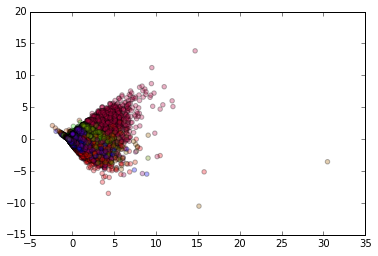

In [11]:
plt.scatter(x,y, c=km_labels, cmap=plt.cm.brg, alpha = .3)

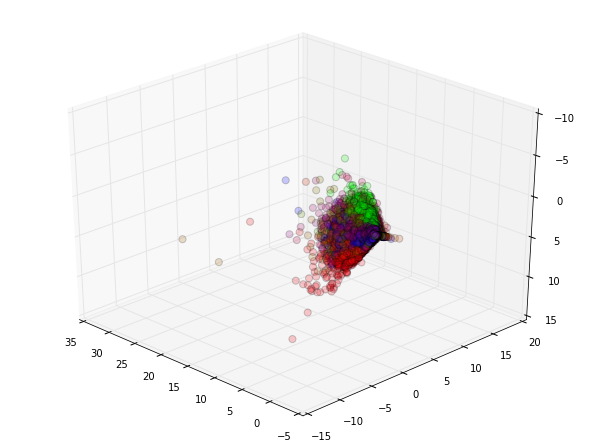

In [12]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=45)
ax.scatter(x, y, z, c= km_labels,
           cmap=plt.cm.brg, alpha = .2, s = 50)

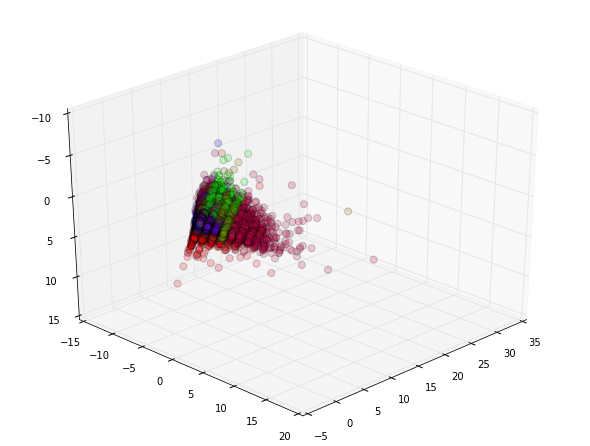

In [13]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=-45)
ax.scatter(x, y, z, c= km_labels,
           cmap=plt.cm.brg, alpha = .2, s = 50)

In [14]:
#save the label for each customer provided by the Clustering
df_org_cluster = pd.DataFrame(zip(df_cluster.index,km_labels),columns = ['org','org_cluster']).set_index('org')


#Prepare Data for Recommender System

In [15]:
#use data only > 2014 to train and test
df_model = df[df.transaction_date >= '2014-01-01 00:00:00.000']

In [16]:
#obtain a dataframe with 1 row per customer
idx_max_tran = df_model.reset_index().groupby('org')[['index','transaction_date']].max()['index'].tolist()

In [17]:
#obtain useful features 
df_model = df_model.ix[idx_max_tran][['org','org_type', 'org_subtype', 'budget',
                                      'reg_date', 'role', 'country']].set_index('org')

In [18]:
#create features: transform reg_date into a timedelta
df_model['years_since_base'] = df_model.reg_date.map(lambda x: (x - np.datetime64('2000-01-01 00:00:00.000'))/datetime.timedelta(days=1))

In [19]:
#remove reg_date and use years_since_base
df_model = df_model.drop('reg_date',axis=1)

In [20]:
%%time
#shape  y into n_orgs X m_items
#create a dataframe for all the y (each product)
df_items = df[df.transaction_date >= '2014-01-01 00:00:00.000']
df_items = df_items[['org','item']].set_index('org')
df_items = pd.get_dummies(df_items.item)
df_items = df_items.groupby(df_items.index).sum()

CPU times: user 8.04 s, sys: 4.86 s, total: 12.9 s
Wall time: 12.9 s


In [21]:
%%time
#create filter to remove items that are purchased infrequently (<100)
df_items_sum = df_items.sum()
cols = df_items_sum[df_items_sum>=100].index

CPU times: user 12.5 s, sys: 1.1 s, total: 13.6 s
Wall time: 13.6 s


In [76]:
#create final y targets dataframe with same customers as X
#use filter to remove infrequently purchased items (<100)
df_y = df_items.ix[df_model.index,cols]

In [77]:
#create final X features dataframe 
df_X = df_model.join([df_org_cluster,val_sum_df,val_count_df, licenses_sum_df])

In [78]:
#check shapes of dataframes
print df_X.shape
print df_y.shape


(141419, 31)
(141419, 352)


In [80]:
#assign customers with no previous purchase history to a cluster
df_X.loc[df_X.org_cluster.isnull(), 'org_cluster'] = 20

#impute null or 'bad' columns'
df_X.loc[df_X.role.isnull(), 'role'] = 0
df_X.loc[(df_X.budget < 0)|(df_X.budget.isnull()), 'budget'] = 0
df_X = df_X.fillna(0)

In [81]:
#label encode categorical variables
for i in ['org_subtype','country']:
    label_encoder = preprocessing.LabelEncoder()
    df_X[i] = label_encoder.fit_transform(df_X[i])

In [82]:
#flag each y-target as 1 if customer purhcased item
for i in df_y.columns:
    df_y.loc[df_y[i]>0,i]=1

In [129]:
#split data into train and test
def train_test(index, i):
    #returns a random selection of the index of the dataframe
    return random.sample(index, int(i*len(index)))

rows = train_test(df_X.index, 0.25)

X_test = df_X.ix[rows,:].values
y_test = df_y.ix[rows,:].values

X_train = df_X.drop(rows).values
y_train = df_y.drop(rows).values

In [130]:
#check shape of each matrix
print X_train.shape
print X_test.shape
print y_train.shape
print y_test.shape

(106065, 31)
(35354, 31)
(106065, 352)
(35354, 352)


#Recommender System using Random Forest 

In [131]:
#create dictionaries to keep records of everything 
rf_log_loss_scores = {}
rf_y_predicted_probas = {}
rf_estimators = {}
rf_clfs = {}
rf_feature_importances = {}



In [132]:
%%time
#iterate Random Forest Model to predict on y-targets
for i in range(len(y_train[1])):
        y_iter_train = y_train[:,i]
        y_iter_test = y_test[:,i]
        
        clf = RandomForestClassifier(n_jobs = -1, n_estimators=500)
        clf.fit(X_train, y_iter_train)

        y_predicted_proba = clf.predict_proba(X_test)
        log_loss_score = log_loss(y_iter_test, y_predicted_proba)
        
        rf_y_predicted_probas[i] = y_predicted_proba
        rf_log_loss_scores[i] = log_loss_score
        rf_clfs[i] = clf
        rf_estimators[i] = clf.estimators_
        rf_feature_importances[i] = clf.feature_importances_

CPU times: user 10h 31min 30s, sys: 13min 34s, total: 10h 45min 4s
Wall time: 25min 52s


In [133]:
#obtain the average of the feature importances for each model
df_feature_importances = pd.DataFrame.from_dict(rf_feature_importances)
df_feature_importances['features'] = df_X.columns
df_feature_importances = df_feature_importances.set_index('features')
df_feature_importances = df_feature_importances.transpose().mean()
df_feature_importances = pd.DataFrame(df_feature_importances, columns = ['importance']).sort(columns = 'importance', ascending = False)
df_feature_importances

,importance
features,
years_since_base,0.200344
budget,0.170720
org_subtype,0.080361
country,0.060441
val_sum_2013,0.048507
org_type,0.041899
val_sum_2012,0.036280
licenses_sum_2013,0.031512
val_sum_2011,0.026592


In [202]:
df_feature_importances.to_csv('feature_importances.csv')

#Check How Well the Recommender Performed
using the y probability scores and the y actual 

In [178]:
#create data frames
df_proba = pd.DataFrame(range(0,len(y_test)))
df_test = pd.DataFrame(range(0,len(y_test)))

In [180]:
#create append records to dataframes
for i in range(0,len(y_test[0])):
    name = 'proba ' + str(i)
    df_proba[name] = rf_y_predicted_probas[i][:,1]
    
for i in range(0,len(y_test[0])):
    name = 'test ' + str(i)
    df_test[name] = y_test[:,i]
    
df_test = df_test.ix[:,1:]
df_proba = df_proba.ix[:,1:]

In [193]:
%%time
#create a list of Top 5 recommendations for each customer based on probability
Of5 = []
for i in df_test.index:
    temp_zip = zip(df_test.ix[i].values, df_proba.ix[i].values)
    temp_df = pd.DataFrame(temp_zip).sort(columns = 1, ascending = False)
    Of5.append(temp_df.head(5).sum()[0])

CPU times: user 52.7 s, sys: 3.9 s, total: 56.6 s
Wall time: 56.6 s


In [196]:
#probability of a single top 5 recommended item being bought
print (sum(Of5) / 5) / len(Of5)
#probability that 1 or more reccomended item being bought
print 1 - itemfreq(Of5)[0][1]/len(Of5)

0.180290773321
0.901453866606


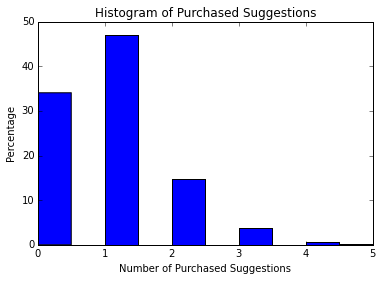

In [195]:
plt.title('Histogram of Purchased Suggestions')
plt.xlabel('Number of Purchased Suggestions')
plt.ylabel('Percentage')
plt.hist(Of5,bins = 10, weights=(np.zeros_like(Of5) + 1. / len(Of5))*100);

In [38]:
#save everything in a pickled file
import pickle

with open('rf_log_loss_scores.p', 'wb') as handle:
    pickle.dump(rf_log_loss_scores, handle)

with open('rf_y_predicted_probas.p', 'wb') as handle:
    pickle.dump(rf_y_predicted_probas, handle)
    
with open('rf_feature_importances.p', 'wb') as handle:
    pickle.dump(rf_feature_importances, handle)
    
with open('X_test.p', 'wb') as handle:
    pickle.dump(X_test, handle)

with open('y_test.p', 'wb') as handle:
    pickle.dump(y_test, handle)
    

In [ ]:
with open('rf_estimators.p', 'wb') as handle:
    pickle.dump(rf_estimators, handle)

with open('rf_clfs.p', 'wb') as handle:
    pickle.dump(rf_clfs, handle)


#ROC Curve
see documentation
http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

In [203]:
#function that creates a roc curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def plot_roc_curve(target_test, target_predicted_proba):
    fpr, tpr, thresholds = roc_curve(target_test, target_predicted_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure(figsize = (10,10))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

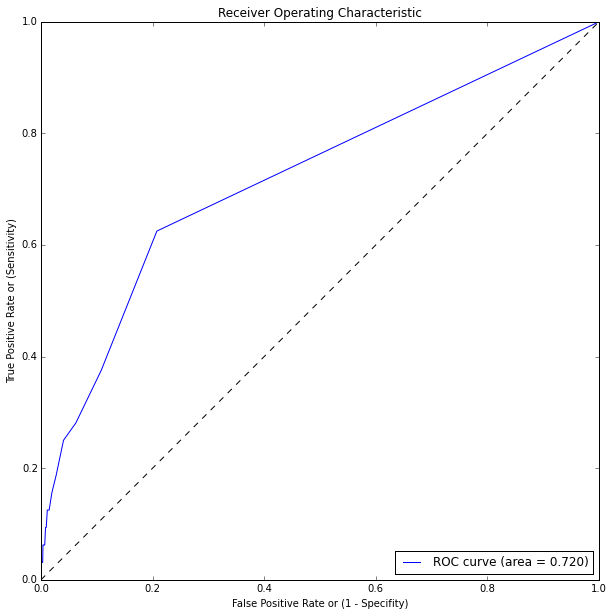

In [215]:
#change 201 to see roc curves for different products 

plot_roc_curve(y_test[:,201], rf_y_predicted_probas[201])

#make Ipython Widget here